In [1]:
import findspark
findspark.init()
import pyspark # only run after findspark.init()

from pyspark.sql import SparkSession
from pyspark.context import SparkContext 
spark = SparkSession.builder.getOrCreate()#create spark session 

from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                DecimalType,
                                LongType,
                                ArrayType,
                                TimestampType)


In [2]:
#Sensor Meta Data File Format
#The header line of the sensor meta data files is as follows:
#serial,latitude,longitude,height,type
#serial: the so called "serial number" of each sensor is a globally unique identifier for each sensor. 
#It can be used to join sensor meta information with measurement data.
#It is a signed integer and can therefore be negative.
#latitude/longitude/height: the three-dimensional location of the receiver.
#Latitude and longitude are in decimal degrees (WGS84), height is in meters.
#Note that this information is of varying/unknown accuracy since receiver locations are reported to the OpenSky Network in different ways.
#For sensors of type dump1090, these location are entered by the users themselves. 
#Most users use services such as Google Maps or their smart phones to determine the location of their antenna. 
#This process is prone to errors, but errors should usually be in the range of meters.
#Other users report wrong locations intentionally to masquerade their exact location for privacy reasons. 
#In this case, locations might be off by several kilometers. 
#For sensors of types Radarcape or GRX1090 the locations should generally be more accurate since they are automatically reported by the integrated GPS receivers and the GPS antenna is usually located close to the ADS-B antenna.
#type: the type of the receiver setup. The OpenSky Network currently supports sensors based on the open-source Mode S software decoder dump1090 and the commercial off-the-shelf devices Radarcape, SBS-3, and GRX1090.
#The device type also determines the measurement noise distribution and timestamp accuracy. However, note that these things also depend on many other factors (e.g., temperature, inside/outdoor deployment, ...).
sensors_schema = StructType([StructField("serial", LongType(), True),
                            StructField("latitudes", DoubleType(), True ),
                            StructField("longitudes",DoubleType(), True),
                            StructField("height",DoubleType(), True),
                            StructField("type", StringType(), True)
                            ])


#Column descriptions

#1*serial: unique sensor ID which can be used to join the sensor information with the measurements data.
#2*latitude: latitude of the sensor in decimal degrees. 
# It has been reported either by the sensor hardware or manually by the sensor operator.
#3*longitude: longitude of the sensor in decimal degrees.
#It has been reported either by the sensor hardware or manually by the sensor operator.
#4*height: height of the sensor in meters.
#Is has been reported either by the sensor hardware or manually by the sensor operator.
#5*type: type of the sensor hardware that was used to record the measurements.



sensors = spark.read.csv("C:/PFE/TEST/sensors.csv",
                       header = True, 
                        schema = sensors_schema)

sensors.show(10)

+------+-----------+----------+--------+---------+
|serial|  latitudes|longitudes|  height|     type|
+------+-----------+----------+--------+---------+
|     1|46.68106661|7.66531348|680.9232|    SBS-3|
|     2|  40.337042| -3.770206|735.7872|    SBS-3|
|     3|        0.0|       0.0|     0.0|    SBS-3|
|     4|  47.143056|  7.243889| 550.164|    SBS-3|
|     5|  52.356455|  4.952216|     0.0| dump1090|
|     6|    47.1742|    8.5247|     0.0|Radarcape|
|     7|  38.898671| 22.430724| 60.0456|Radarcape|
|     8|  47.849913|12.1293481|  137.16|    SBS-3|
|     9| 45.4109439|11.8875289|     0.0|Radarcape|
|    10|   47.40017|   8.63068|430.6824|Radarcape|
+------+-----------+----------+--------+---------+
only showing top 10 rows



In [3]:

#Measurement Data File Format

#The header line of the measurement data files is as follows:
#id,timeAtServer,aircraft,latitude,longitude,baroAltitude,geoAltitude,numMeasurements,measurements

#1-id: a unique identifier for each received transponder signal. This identifier will be used to join the result file (output of your localization algorithm) with the measurement data.
#2-timeAtServer: a timestamp (double) in seconds indicating the time when the information was received by OpenSky's ingestion server.
#In each 1h data set, this timestamp starts with 0 and counts up to 3600 seconds. 
#This timestamp has roughly millisecond accuracy. 
#Note that this timestamp was determined after propagation delay, processing delay, and Internet delay.
#3-aircraft: an aircraft identifier which is unique for each aircraft within each data set. 
#This identifier allows grouping the measurements that belong to signals from the same transponder.
#Note that aircraft 123 in data set X is not the same transponder as aircraft 123 in data set Y. 
#This means that data sets cannot be combined.
#4-latitude/longitude/geoAltitude: the location that was reported by the transmitting aircraft. 
#As in the sensor meta data, latitude and longitude are provided in decimal degrees (WGS84), geoAltitude in meters. 
#The accuracy of these location information is generally unknown. 
#However, most aircraft should report their locations at a decent accuracy (10s of meters accuracy). 
#It is worth noting here that there are some aircraft sending location information derived from their intertial system rather that their GPS sensor.
#In this case, location information is subject to drifting and might be wrong by several hundred meters. 
#However, this case is rather rare but should nevertheless be considered when cleansing the data.
#5-baroAltitude: the barometric altitude reported by the aircraft in meters. 
#Note that the barometric altitude is weather dependent and might differ from the geometric altitude by several hundred meters.
#However, the difference might be learned from "known" aircraft and this information could then be used to estimate the geometric altitude or estimate bounds.
#6-numMeasurements: the number of measurements, i.e., the number of sensors which received this particular transponder signal.
#7-measurements: the measurement data for each receiver which received this particular transponder signal. 
#The measurement data is provided as a JSON array string containing triples.
#Each triple contains the serial number of the sensor which reported the measurement data, the timestamp for the time of arrival of the signal at the receiver (in nanoseconds), and the received signal strength indicator (RSSI).
#The exact definition of the RSSI depends on the type of receiver but is usually provided in dB. 
#The properties of the nanosecond timestamp also strongly depend of the type of receiver. 
#For dump1090 receivers, these timestamps are generally unsynchronized and typically have a 12MHz resolution. 
#Unsynchronized timestamp means in particular that these timestamps are subject to (sometimes heavy) drifting. 
#For Radarcape and GRX1090, these timestamps are usually GPS synchronized and have a resolution of about 40-60MHz. GPS synchronized means that they are constantly resynchronized to compensate for clock drift.
sample_schema = StructType([StructField("id",  IntegerType(), True),
                            StructField("timeAtServer", DoubleType(), True),
                            StructField("aircraft",  IntegerType(), True ),
                            StructField("latitude", DoubleType(), True),
                            StructField("longitude", DoubleType(), True  ),
                            StructField("baroAltitude", DoubleType(), True ),
                            StructField("geoAltitude", DoubleType(), True ),
                            StructField("numMeasurements",IntegerType(), True),
                            StructField("measurements", StringType(), True)           
                            ])
                               

sample_aircarft = spark.read.csv("C:/PFE/TEST/sample.csv",
                       header = True, 
                        schema = sample_schema)


sample_aircarft.show()


+---+-------------------+--------+----------------+------------------+------------+-----------+---------------+--------------------+
| id|       timeAtServer|aircraft|        latitude|         longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|
+---+-------------------+--------+----------------+------------------+------------+-----------+---------------+--------------------+
|  1|                0.0|    1787|49.5238952636719|  7.80282271535773|      6400.8|    6537.96|              3|[[463,963309455,4...|
|  2|                0.0|    1605|50.4821311821372|  7.35423320048564|     10363.2|   10500.36|              5|[[463,963756980,2...|
|  3|                0.0|    2022|45.9829505015228|  8.61870574951172|     11277.6|   11445.24|              3|[[14,981538828,29...|
|  4|0.00100016593933105|    2359|47.8106379104873|  9.30739182692308|     10820.4|   10965.18|              2|[[125,957894484,8...|
|  5|0.00100016593933105|    1283|49.8303533004502|  5.40037412901183

In [4]:
#drop null data 
#remove duplicate data 
#filter Na and null  values for lat , long,measurements ,geoAltitude,baroAltitude
sample_aircarft.na.drop()
sample_aircarft.dropDuplicates()
sample_aircarft=sample_aircarft.filter((sample_aircarft.latitude !=0) & (sample_aircarft.longitude != 0) & (sample_aircarft.baroAltitude != 0)& (sample_aircarft.measurements != 'NA'))
sample_aircarft.head(5)


[Row(id=1, timeAtServer=0.0, aircraft=1787, latitude=49.5238952636719, longitude=7.80282271535773, baroAltitude=6400.8, geoAltitude=6537.96, numMeasurements=3, measurements='[[463,963309455,4],[424,963315122,27],[412,963373222,0]]'),
 Row(id=2, timeAtServer=0.0, aircraft=1605, latitude=50.4821311821372, longitude=7.35423320048564, baroAltitude=10363.2, geoAltitude=10500.36, numMeasurements=5, measurements='[[463,963756980,25],[238,963870125,32],[115,963663562,91],[412,963820222,34],[394,963815875,138]]'),
 Row(id=3, timeAtServer=0.0, aircraft=2022, latitude=45.9829505015228, longitude=8.61870574951172, baroAltitude=11277.6, geoAltitude=11445.24, numMeasurements=3, measurements='[[14,981538828,29],[10,981594515,90],[477,981465852,6]]'),
 Row(id=4, timeAtServer=0.00100016593933105, aircraft=2359, latitude=47.8106379104873, longitude=9.30739182692308, baroAltitude=10820.4, geoAltitude=10965.18, numMeasurements=2, measurements='[[125,957894484,84],[123,957583812,94]]'),
 Row(id=5, timeAtSe

In [5]:
#in this stage , we create an array of measurements 
#we explode this array
#we transorform each barcklet 
#for each , we extract sensor informations [sensorID, timestamp, signalstrength]
from pyspark.sql.functions import *
sample_aircarft = sample_aircarft.withColumn("ArrayOfString", split(col("measurements"), "\],\s*\[").cast(ArrayType(StringType())).alias("ArrayOfString"))
                                           
sample_aircarft = sample_aircarft.withColumn("sensors informations",explode_outer('ArrayOfString'))

sample_aircarft=sample_aircarft.withColumn("sensors informations", regexp_replace(col("sensors informations"), "[\\[\\]]", ""))
sample_aircarft=sample_aircarft.withColumn("sensors informations",split(col("sensors informations"), ",\s*").cast(ArrayType(IntegerType())).alias("sensors informations"))
sample_aircarft = sample_aircarft.withColumn("serial", sample_aircarft["sensors informations"].getItem(0))
sample_aircarft = sample_aircarft.withColumn("timestamp", sample_aircarft["sensors informations"].getItem(1))
sample_aircarft = sample_aircarft.withColumn("signalstrength", sample_aircarft["sensors informations"].getItem(2))
sample_aircarft.dropDuplicates()
sample_aircarft.select('aircraft','latitude','longitude','geoAltitude','measurements','serial','timestamp','signalstrength').show(10)


+--------+----------------+----------------+-----------+--------------------+------+---------+--------------+
|aircraft|        latitude|       longitude|geoAltitude|        measurements|serial|timestamp|signalstrength|
+--------+----------------+----------------+-----------+--------------------+------+---------+--------------+
|    1787|49.5238952636719|7.80282271535773|    6537.96|[[463,963309455,4...|   463|963309455|             4|
|    1787|49.5238952636719|7.80282271535773|    6537.96|[[463,963309455,4...|   424|963315122|            27|
|    1787|49.5238952636719|7.80282271535773|    6537.96|[[463,963309455,4...|   412|963373222|             0|
|    1605|50.4821311821372|7.35423320048564|   10500.36|[[463,963756980,2...|   463|963756980|            25|
|    1605|50.4821311821372|7.35423320048564|   10500.36|[[463,963756980,2...|   238|963870125|            32|
|    1605|50.4821311821372|7.35423320048564|   10500.36|[[463,963756980,2...|   115|963663562|            91|
|    1605|

In [6]:
sample_aircarft.printSchema()
sensors.printSchema()

root
 |-- id: integer (nullable = true)
 |-- timeAtServer: double (nullable = true)
 |-- aircraft: integer (nullable = true)
 |-- latitude: double (nullable = true)
 |-- longitude: double (nullable = true)
 |-- baroAltitude: double (nullable = true)
 |-- geoAltitude: double (nullable = true)
 |-- numMeasurements: integer (nullable = true)
 |-- measurements: string (nullable = true)
 |-- ArrayOfString: array (nullable = true)
 |    |-- element: string (containsNull = true)
 |-- sensors informations: array (nullable = true)
 |    |-- element: integer (containsNull = true)
 |-- serial: integer (nullable = true)
 |-- timestamp: integer (nullable = true)
 |-- signalstrength: integer (nullable = true)

root
 |-- serial: long (nullable = true)
 |-- latitudes: double (nullable = true)
 |-- longitudes: double (nullable = true)
 |-- height: double (nullable = true)
 |-- type: string (nullable = true)



In [7]:
#jointure spatial sesnors data + aircrafts data , i used inner join 
#i used spark sql to join our data 
sample_aircarft.createOrReplaceTempView("datafilghts")
sensors.createOrReplaceTempView("sensors")

joinedflights = spark.sql("SELECT datafilghts.*, sensors.* FROM datafilghts INNER JOIN sensors ON datafilghts.serial == sensors.serial")
joinedflights .show(5)

+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+---------+--------------+------+----------------+----------------+----------+---------+
| id|       timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|       ArrayOfString|sensors informations|serial|timestamp|signalstrength|serial|       latitudes|      longitudes|    height|     type|
+---+-------------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+---------+--------------+------+----------------+----------------+----------+---------+
|  1|                0.0|    1787|49.5238952636719|7.80282271535773|      6400.8|    6537.96|              3|[[463,963309455,4...|[[[463,963309455,...| [463, 963309455, 4]|   463|963309455|          

In [8]:
#group our data by aicrafts 
gr_filghts = joinedflights .groupby(['aircraft'])
gr_filghts.count().show()

+--------+-----+
|aircraft|count|
+--------+-----+
|    2580|   77|
|    2387|   78|
|    2235|   88|
|     540|   45|
|     737|   20|
|    1352|   37|
|     516|   73|
|    1270|    4|
|    2443|  105|
|    2525|   34|
|    2748|    2|
|     481|   87|
|     898|  120|
|    1157|    8|
|    1787|  145|
|     472|   46|
|     296|  131|
|    1466|   63|
|    2238|   29|
|    1888|   17|
+--------+-----+
only showing top 20 rows



In [9]:
#sort our data  by distinct aircraft and time at server 
sorted_flights = joinedflights .orderBy('aircraft','timeAtServer')
sorted_flights.show()

+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+---------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|       ArrayOfString|sensors informations|serial| timestamp|signalstrength|serial|latitudes|longitudes|   height|     type|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+---------+
| 299|0.523000001907349|       2|49.8963643736759|8.40246252111487|      2400.3|     2400.3|              3|[[440,1509552325,...|[[[440,1509552325...|[463, 1509722780,...|   463|1509722780|            34|   463|49.471601|  7.696532|  273.985

In [10]:
#exapmle of a flight trip 2443
sorted_flights.filter('aircraft= 2443').show(10)

+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+----------+---------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|       ArrayOfString|sensors informations|serial| timestamp|signalstrength|serial|latitudes|longitudes|    height|     type|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+----------+---------+
| 195|0.384000062942505|    2443| 50.341403767214|6.53738485800253|     7940.04|     8115.3|              3|[[436,1358836953,...|[[[436,1358836953...|[115, 1358729625,...|   115|1358729625|            89|   115|50.937081|  7.353797|262.31

In [12]:
t2= spark.read.csv("C:/PFE/TEST/t1.csv")
t3= spark.read.csv("C:/PFE/TEST/t2.csv")
t4= spark.read.csv("C:/PFE/TEST/header.csv")
t2.show(5)
t3.show(5)
t4.show(5)
sorted_flights.printSchema()
t4.head()

+---------+------+------------------+--------------------+------+------------------+------------------+---+
|      _c0|   _c1|               _c2|                 _c3|   _c4|               _c5|               _c6|_c7|
+---------+------+------------------+--------------------+------+------------------+------------------+---+
|  GRX1090|u0v3rn| 5.983492407411455|1.2661237838487739E7|u0v99x|          6263.975|2.1428571428571406|  4|
|  GRX1090|u0v90m|7.1863214028947855|   7236350.243007009|u0v99x|          6260.945|2.1428571428571406| 27|
|  GRX1090|u0v2mh| 18.61448097967346|   8532266.517099017|u0v99x|          6127.308|2.1428571428571406|  0|
|  GRX1090|u0v3rn| 71.45463850655925|   7440449.203457598|u0vppm|         10226.375|1.3235294117647043| 25|
|Radarcape|u1jkuu| 70.20053015736349|   8583267.707449172|u0vppm|10353.760299000001|1.3235294117647043| 32|
+---------+------+------------------+--------------------+------+------------------+------------------+---+
only showing top 5 rows

+--

Row(_c0='sensor_type', _c1='sensor_geohash', _c2='distance', _c3='distance3d', _c4='aircarft_geohash', _c5='delta_geo_alt_sensor_aircraft', _c6='delta_geo_baro_alt', _c7='signal_strength')

In [13]:
#create new column 
#1)sensor_type
#2)sensor_geohash : geohash du sensor ou se trouve t il?
#3)distance: distance entre le sensor et le aircraft en considerant lat et lon
#4)distance3d, distance entre le sensor et le aircraft en considerant lat et lon et alt
#5)aircarft_geohash, geohash du aircraft
#6)delta_geo_alt_sensor_aircraft, difference des altitudes celle du sensor et celle de l'aircraft
#7)delta_geo_baro_alt, difference des altitudes baro et geo du aircraft
#9)signal_strength: force du signal

import geohash2
import pyspark.sql.functions as F
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pyspark.sql.functions import lit
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                               TimestampType)

sorted_flights.baroAltitude.cast(DoubleType())
sorted_flights.geoAltitude.cast(DoubleType())
sorted_flights.height.cast(DoubleType())
sorted_flights.latitude.cast(DoubleType()) 
sorted_flights.longitude.cast(DoubleType()) 
sorted_flights.latitudes.cast(DoubleType()) 
sorted_flights.longitudes.cast(DoubleType()) 


udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=6))
udf2= F.udf(lambda x,y,z,t: geodesic((x,y),(z,t)))
sorted_flights=sorted_flights.withColumn('Hashcode aircraft', udf1('latitude','longitude'))
sorted_flights=sorted_flights.withColumn('Hashcode sensors', udf1('latitudes','longitudes'))
sorted_flights.show(5)


+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+---------+-----------------+----------------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|       ArrayOfString|sensors informations|serial| timestamp|signalstrength|serial|latitudes|longitudes|   height|     type|Hashcode aircraft|Hashcode sensors|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+---------+-----------------+----------------+
| 299|0.523000001907349|       2|49.8963643736759|8.40246252111487|      2400.3|     2400.3|              3|[[440,1509552325,...|[[[440,

In [14]:
import geohash2
import pyspark.sql.functions as F
from pyspark.sql.functions import udf,col
from pyspark.sql.types import IntegerType
from pyspark.sql.types import *
from pyspark.sql.functions import udf
import pandas as pd
from math import radians, cos, sin, asin, sqrt
from geopy.distance import geodesic
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
from pyspark.sql.functions import lit
from pyspark.sql.types import  (StructType, 
                                StructField, 
                                DateType, 
                                BooleanType,
                                DoubleType,
                                IntegerType,
                                StringType,
                                TimestampType)

# we have two method to calculate distance betwen two point :haversine vs geodisc(vincey)
#==> Vincenty is more accurate 
def haversine(coord1, coord2):
    R = 6372800  # Earth radius in meters
    lat1, lon1 = coord1
    lat2, lon2 = coord2
    
    phi1, phi2 = math.radians(lat1), math.radians(lat2) 
    dphi       = math.radians(lat2 - lat1)
    dlambda    = math.radians(lon2 - lon1)
    
    a = math.sin(dphi/2)**2 + \
        math.cos(phi1)*math.cos(phi2)*math.sin(dlambda/2)**2
    
    return 2*R*math.atan2(math.sqrt(a), math.sqrt(1 - a))

def get_distance_2d(lat_1, lng_1, lat_2, lng_2): 
    A =(lat_1, lng_1)
    B = (lat_2, lng_2)
    d=geodesic(A, B).kilometers
    return d
def get_distance_3d(distance_2d, alt1, alt2): 
    distance_3d = sqrt(distance_2d**2+(alt2-alt1)**2)
    return  distance_3d
def get_Difference( alt1, alt2): 
    Difference= alt1-alt2
    return Difference
udf_get_distance_2d = F.udf(get_distance_2d)
udf_get_distance_3d = F.udf(get_distance_3d)
udf_get_Difference = F.udf(get_Difference)
sorted_flights=sorted_flights.withColumn('Distance_2d', udf_get_distance_2d('latitude','longitude','latitudes','longitudes').cast(DoubleType()))
sorted_flights.Distance_2d.cast(DoubleType())
sorted_flights=sorted_flights.withColumn('Distance_3d', udf_get_distance_3d('Distance_2d','geoAltitude','height').cast(DoubleType()))
 #6)delta_geo_alt_sensor_aircraft, difference des altitudes celle du sensor et celle de l'aircraft
#7)delta_geo_baro_alt, difference des altitudes baro et geo du aircraft
sorted_flights=sorted_flights.withColumn('delta_geo_alt_sensor_aircraft', udf_get_Difference('geoAltitude','height'))
sorted_flights=sorted_flights.withColumn('delta_geo_baro_alt', udf_get_Difference('geoAltitude','baroAltitude'))
sorted_flights.Distance_3d.cast(DoubleType())
sorted_flights.show()


+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+---------+-----------------+----------------+------------------+------------------+-----------------------------+------------------+
|  id|     timeAtServer|aircraft|        latitude|       longitude|baroAltitude|geoAltitude|numMeasurements|        measurements|       ArrayOfString|sensors informations|serial| timestamp|signalstrength|serial|latitudes|longitudes|   height|     type|Hashcode aircraft|Hashcode sensors|       Distance_2d|       Distance_3d|delta_geo_alt_sensor_aircraft|delta_geo_baro_alt|
+----+-----------------+--------+----------------+----------------+------------+-----------+---------------+--------------------+--------------------+--------------------+------+----------+--------------+------+---------+----------+---------+--------

In [15]:
sorted_flights.select(max('timeAtServer')).show()

+-----------------+
|max(timeAtServer)|
+-----------------+
| 18.4260001182556|
+-----------------+



In [16]:

sorted_flights.select('type','Hashcode sensors','Distance_2d', 'Distance_3d','Hashcode aircraft','delta_geo_alt_sensor_aircraft','delta_geo_baro_alt','signalstrength').show()

+---------+----------------+------------------+------------------+-----------------+-----------------------------+------------------+--------------+
|     type|Hashcode sensors|       Distance_2d|       Distance_3d|Hashcode aircraft|delta_geo_alt_sensor_aircraft|delta_geo_baro_alt|signalstrength|
+---------+----------------+------------------+------------------+-----------------+-----------------------------+------------------+--------------+
|  GRX1090|          u0yh9p| 18.00518279571504|2317.9889294749682|           u0vgz5|           2317.9190000000003|               0.0|            24|
|Radarcape|          u0yh9p|18.002746399993125| 2307.749576749288|           u0vgz5|                  2307.679356|               0.0|            46|
|  GRX1090|          u0v3rn|  69.4771329881194|  2127.44977643028|           u0vgz5|                     2126.315|               0.0|            34|
|Radarcape|          u0yh9p|18.070177029926292|2315.3698709260057|           u0vgz5|                  2315

In [17]:
sorted_flights.groupBy("type").count().show()

+---------+-----+
|     type|count|
+---------+-----+
|  GRX1090| 4474|
|Radarcape|22468|
+---------+-----+



In [18]:


import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt
t1=sorted_flights.groupBy("type").count()
#We can also use matplotlib and Pandas to visualize the total number of crimes per year
import pandas as pd

%matplotlib inline
t1_pandas_DataFrame = pd.DataFrame.from_records(t1.collect(), columns=t1.columns)
t1_pandas_DataFrame.head(20)



,type,count
0,GRX1090,4474
1,Radarcape,22468


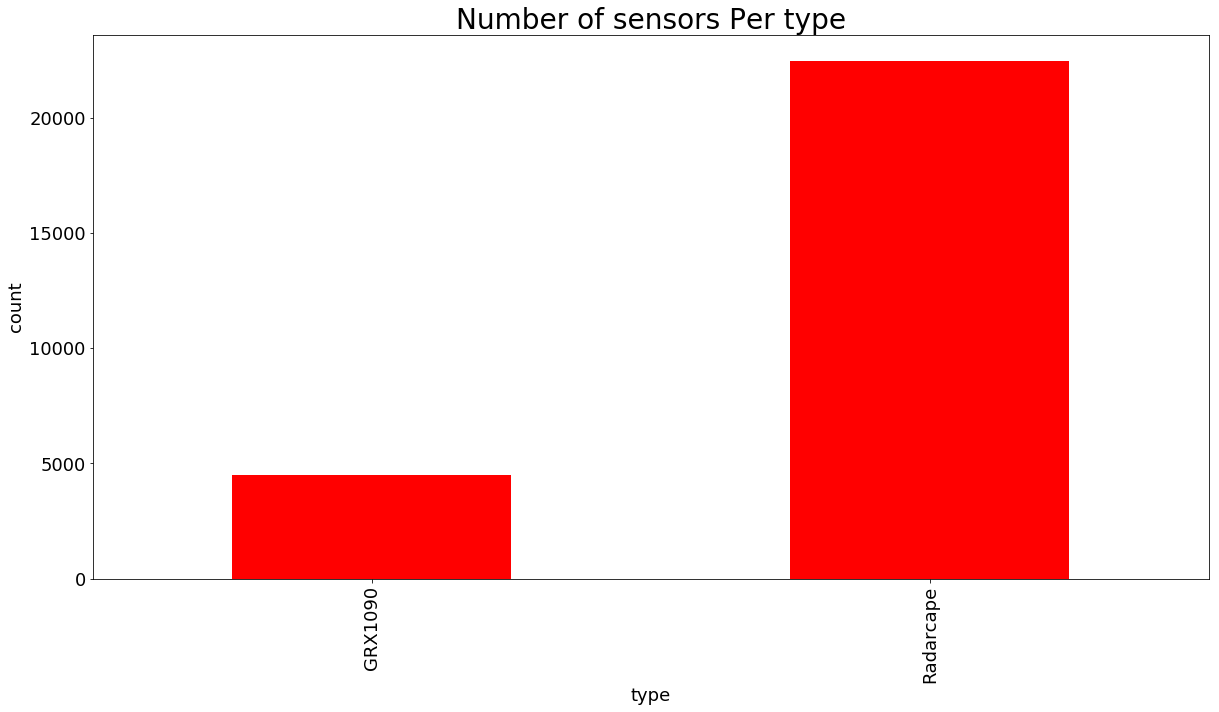

In [19]:
t1_pandas_DataFrame.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "type", y = "count", legend = False)

plt.xlabel("type", fontsize = 18)
plt.ylabel("count", fontsize = 18)
plt.title("Number of sensors Per type", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()

In [20]:
sorted_flights.describe("Distance_3d").show()

+-------+------------------+
|summary|       Distance_3d|
+-------+------------------+
|  count|             26942|
|   mean| 9094.907396151699|
| stddev| 2746.419944372387|
|    min|61.807056960314625|
|    max|13139.861884801641|
+-------+------------------+



In [21]:
his_dataframe=sorted_flights.select("Distance_3d")
his_dataframe.show()

+------------------+
|       Distance_3d|
+------------------+
|2317.9889294749682|
| 2307.749576749288|
|  2127.44977643028|
|2315.3698709260057|
|2325.6092236005134|
| 2322.990009386611|
|2333.2293626294954|
|2142.6770771563934|
|2330.6102552602456|
|2340.8496086233263|
|2363.7098737887604|
|  2353.47051813475|
|2368.7108699296105|
|2378.9502264017888|
|2378.9506511299805|
|2188.3598966400373|
|2383.9512773356487|
|2394.1906343985993|
|2394.1911433290347|
|2203.5876165940176|
+------------------+
only showing top 20 rows



array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000000000C958E10>]],
      dtype=object)

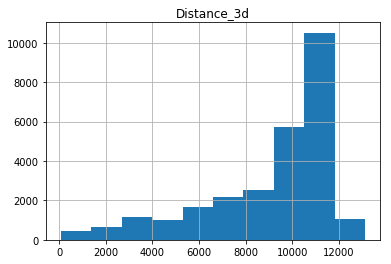

In [22]:
#Histograms are a great way to visualize the distributions of a single variable 
#aand it is one of the must for initial exploratory analysis with fewer variables.
%matplotlib inline
import matplotlib.pyplot as plt
df_pd = pd.DataFrame.from_records(his_dataframe.collect(), columns=his_dataframe.columns)
df_pd.hist(column='Distance_3d')



In [23]:
#its clear from the plot that we have a negative skew 
#let's check that 
from pyspark.sql.functions import col, skewness, kurtosis
his_dataframe.select(skewness('Distance_3d')).show()



+---------------------+
|skewness(Distance_3d)|
+---------------------+
|   -1.309362467820387|
+---------------------+



In [24]:
#Choix du nombre de classes k=1+log2(num of sample alt=N )
#) La représentation par histogramme consiste à regrouper les observations « proches » en classes :
#On trie le vecteur x (noté alors x), et on partitionne l’intervalle ]a0; ak]
#(a0 < x1; ak > xn) en k intervalles ]ai-1; ai] appelés classes.
#La largeur de la classe i est notée hi = ai-(ai-1) (et h = (ak -a0)/k si pas fixe).
# N= count| 26942
#Choix du nombre de classes k=1+log2(26942 )
#a0=  min|61.80705696031462=60
#ak= max|13139.861884801641= 13150
#h = (ak -a0)/k 
k=5
h=2600

In [25]:
#Binning our data , we can use also use cut() with pandas 
#this work will be repeated for the rest of all thecolumn  you want to bin
from pyspark.ml.feature import Bucketizer
from pyspark.sql.functions import udf
from pyspark.sql.types import *
sorted_flights.Distance_3d.cast(DoubleType())
udf1 = F.udf(lambda x,y: geohash2.encode(x,y,precision=6))
float_distance = F.udf(lambda x: float(x), DoubleType() )
bucketizer = Bucketizer(splits=[ 0, 2600, 5200,7800,10400,13150, float('Inf') ],inputCol="Distance_3d", outputCol="buckets")
sorted_flights_buck = bucketizer.setHandleInvalid("keep").transform(sorted_flights)

def categorizer(age):
   if age < 2600:
    return "A"
   elif age <  5200:
    return "B"
   elif age < 7800:
    return "C"
   elif age < 10400:
    return "D"
   else: 
    return "E"
bucket_udf = udf(categorizer, StringType() )
sorted_flights_buck = sorted_flights_buck.withColumn("bucket", bucket_udf("Distance_3d"))
sorted_flights_buck.select("Distance_3d",'buckets','bucket').show(100)

+------------------+-------+------+
|       Distance_3d|buckets|bucket|
+------------------+-------+------+
|2317.9889294749682|    0.0|     A|
| 2307.749576749288|    0.0|     A|
|  2127.44977643028|    0.0|     A|
|2315.3698709260057|    0.0|     A|
|2325.6092236005134|    0.0|     A|
| 2322.990009386611|    0.0|     A|
|2333.2293626294954|    0.0|     A|
|2142.6770771563934|    0.0|     A|
|2330.6102552602456|    0.0|     A|
|2340.8496086233263|    0.0|     A|
|2363.7098737887604|    0.0|     A|
|  2353.47051813475|    0.0|     A|
|2368.7108699296105|    0.0|     A|
|2378.9502264017888|    0.0|     A|
|2378.9506511299805|    0.0|     A|
|2188.3598966400373|    0.0|     A|
|2383.9512773356487|    0.0|     A|
|2394.1906343985993|    0.0|     A|
|2394.1911433290347|    0.0|     A|
|2203.5876165940176|    0.0|     A|
|2216.0183428188075|    0.0|     A|
|2399.1917640403867|    0.0|     A|
| 2409.431121385407|    0.0|     A|
|2406.8118879176927|    0.0|     A|
| 2417.051245829986|    0.0|

In [26]:
t=sorted_flights_buck.groupBy("bucket").count()
t.show()

+------+-----+
|bucket|count|
+------+-----+
|     E|12831|
|     B| 2152|
|     D| 7249|
|     C| 3668|
|     A| 1042|
+------+-----+



In [27]:
import plotly.graph_objs as go
import pandas as pd
import requests
import matplotlib.pyplot as plt

#We can also use matplotlib and Pandas to visualize the total number of each class a,b,c,d,e
import pandas as pd

%matplotlib inline
t_pandas_DataFrame = pd.DataFrame.from_records(t.collect(), columns=t.columns)
t_pandas_DataFrame.head(20)
#from pyspark_dist_explore import hist
#import matplotlib.pyplot as plt
#fig, ax = plt.subplots()
#3hist(ax,DF_3D, bins = 10, color=['red'])
#import matplotlib.pyplot as plt
# Show histogram of the 'Distance_3d' column
#bins, counts = DF_3D.select('Distance_3d').rdd.flatMap(lambda x: x).histogram(10)
#.hist(bins[:-1], bins=bins, weights=counts)
#%matplotlib inline
#import matplotlib.pyplot as plt
#DF_3D_pandas.hist(column='Distance_3d',bins=8)
#sample_aircarfts_DataFrame = pd.DataFrame.from_records(sample_aircarft.collect(), columns=sample_aircarft.columns)
#sensors_DataFrame = pd.DataFrame.from_records(sensors.collect(), columns=sensors.columns)

,bucket,count
0,E,12831
1,B,2152
2,D,7249
3,C,3668
4,A,1042


In [28]:
t_pandas_DataFrame = t_pandas_DataFrame.sort_values(by ='count' )

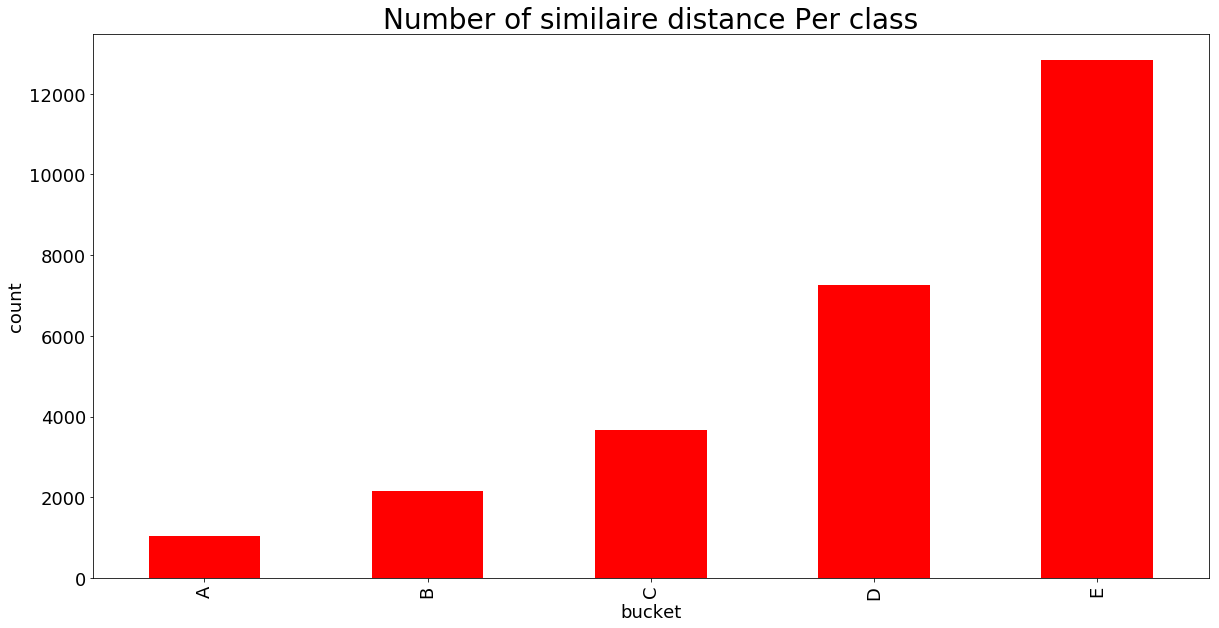

In [29]:
t_pandas_DataFrame.plot(figsize = (20,10), kind = "bar", color = "red",
                               x = "bucket", y = "count", legend = False)

plt.xlabel("bucket", fontsize = 18)
plt.ylabel("count", fontsize = 18)
plt.title("Number of similaire distance Per class", fontsize = 28)
plt.xticks(size = 18)
plt.yticks(size = 18)
plt.show()